<h1 style="background-color:rgb(21, 131, 85); font-family: 'Times New Roman'; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
<b>Weather Image Recognition</b>
</h1>

---

### **Overview**

- Build a deep CNN to classify **11 weather categories**  
- Dataset contains **6,862 labeled images**  
- Each class represents a distinct weather condition  

**Class Labels:**

0 → dew <br>
1 → fogsmog <br>
2 → frost<br>
3 → glaze<br>
4 → hail<br>
5 → lightning<br>
6 → rain<br>
7 → rainbow<br>
8 → rime<br>
9 → sandstorm<br>
10 → snow<br>


**Dataset link**: [Weather Dataset on Kaggle](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset/data)

---

### **Objectives**

- **Baseline CNN from scratch**
  - Design and train a custom CNN architecture  
  - Tune dropout, batch normalization, and pooling to reduce overfitting  

- **Transfer learning with pretrained models**
  - Fine-tune **VGG16**, **MobileNetV2**, **ResNet50**, and **EfficientNetB0**  
  - Replace top classifier layers for 11-class output  
  - Evaluate and compare performance on the same dataset  

- **Handle class imbalance**
  - Compute **class weights** based on class frequency  
  - Apply weights in loss function to improve recall on underrepresented classes  

- **Data augmentation**
  - Apply real-time image transformations: rotation, flipping, zoom, brightness  
  - Improve generalization and model robustness  

- **Performance comparison**
  - Use metrics: **accuracy**, **precision**, **recall**, **F1-score**, **confusion matrix**  
  - Track training/validation accuracy and loss curves  
  - Select the best model based on validation results  


# `00` **Import used libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout , Flatten, GlobalAveragePooling2D , Conv2D , MaxPooling2D , BatchNormalization
from tensorflow.keras.models import Model

tf.random.set_seed(123)


# `01` **Load Dataset**

## **Set Global Parameters**

In [2]:
batch_size  = 32
epochs     = 100
image_size = (224, 224)
seed = 123
early_stop = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5, verbose=1)
]

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omarelgema3y","key":"e98e7949de2349c9af5783097dc5dd1c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jehanbhathena/weather-dataset

Dataset URL: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
License(s): CC0-1.0


In [7]:
!unzip -q weather-dataset.zip -d weather_dataset

In [8]:
import os

train_path = '/content/weather_dataset/dataset'
for root, dirs, files in os.walk(train_path):
    print(f'Found {len(dirs)} folders and {len(files)} files in {root}')
    break


Found 11 folders and 0 files in /content/weather_dataset/dataset


In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
)

Found 6862 files belonging to 11 classes.


## **Class names**

In [ ]:
class_names = list(train_data.class_names)
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


## **Show some data images**

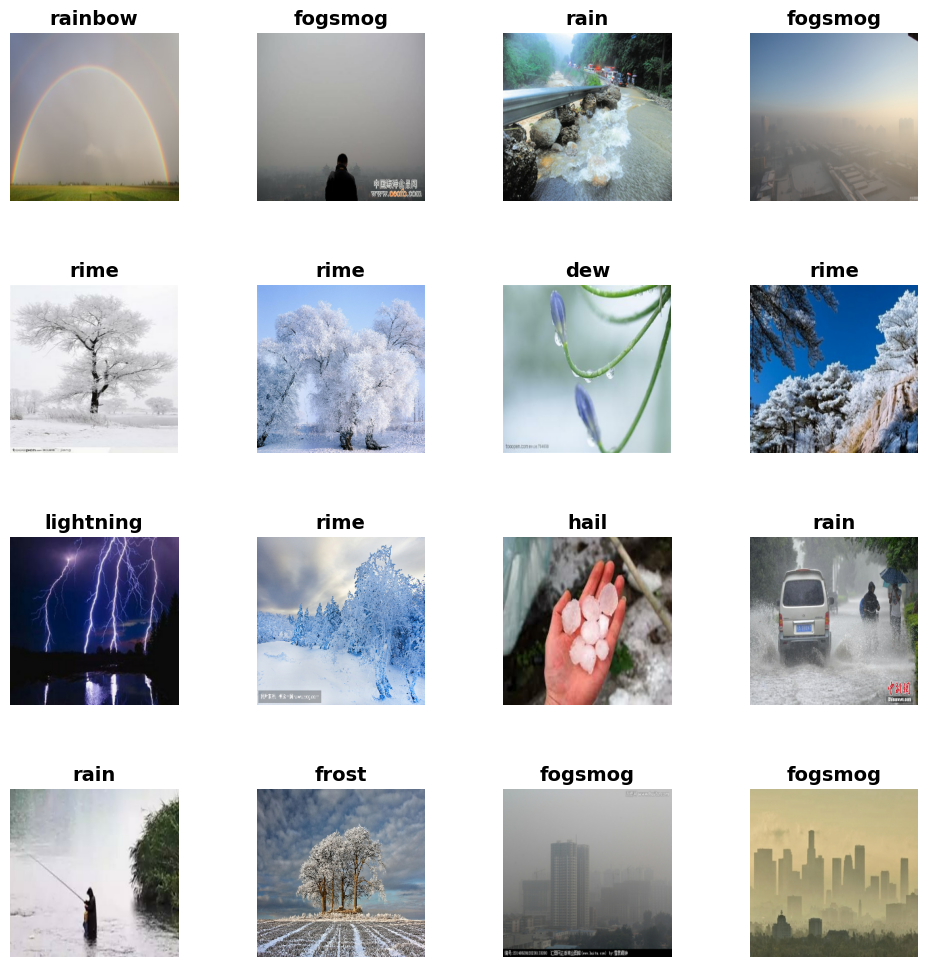

In [ ]:
train_data = iter(train_data)
x, y = next(train_data)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].numpy().astype("uint8"))
    ax.set_title(class_names[int(y[i])], fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.axis('off')
plt.show()

## **Class Distribution**

In [10]:
classes = sorted([i for i in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, i))])
print("Classes:", classes)

class_count = {}
for cls in classes:
    cls_path = os.path.join(train_path, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_count[cls] = len(images)

df = pd.DataFrame(list(class_count.items()), columns=['Class', 'Count'])
df = df.sort_values(by='Count', ascending=False)
print(df)

Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
        Class  Count
8        rime   1160
1     fogsmog    851
0         dew    698
9   sandstorm    692
3       glaze    639
10       snow    621
4        hail    591
6        rain    526
2       frost    475
5   lightning    377
7     rainbow    232


<ipython-input-42-59ee38179de8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df, palette="magma")


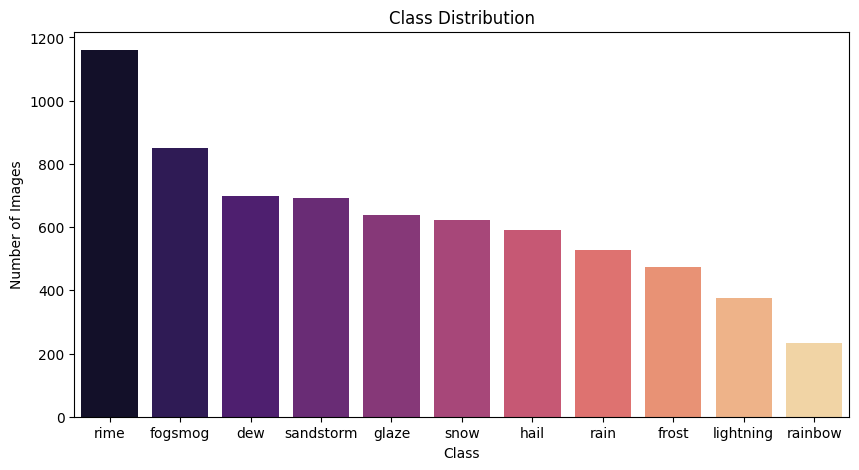

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='Class', y='Count', data=df, palette="magma")
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.show()

## **Class weights**

In [30]:
from sklearn.utils.class_weight import compute_class_weight

class_names = train_scaled_data.class_indices.keys()
class_labels = train_scaled_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.8933159863392421), 1: np.float64(0.7332799359231077), 2: np.float64(1.3141148325358851), 3: np.float64(0.9753196022727273), 4: np.float64(1.055737074764559), 5: np.float64(1.6535219747140277), 6: np.float64(1.186136903476571), 7: np.float64(2.6847507331378297), 8: np.float64(0.5381073667711599), 9: np.float64(0.9013784049885133), 10: np.float64(1.004755807572709)}


# `02` **Modelling**



## `i` **Model Design**
- **pretrained model (ResNet50)**

In [14]:
# preprocess for Resnet model
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_scaled_data = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    seed=seed,
    shuffle=True,
    subset='training'
)

validation_scaled_data = valid_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    seed=seed,
    shuffle=False,
    subset='validation'
)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


In [15]:
import numpy as np
unique, counts = np.unique(validation_scaled_data.classes, return_counts=True)
print("Validation class distribution:", dict(zip(unique, counts)))


Validation class distribution: {np.int32(0): np.int64(139), np.int32(1): np.int64(170), np.int32(2): np.int64(95), np.int32(3): np.int64(127), np.int32(4): np.int64(118), np.int32(5): np.int64(75), np.int32(6): np.int64(105), np.int32(7): np.int64(46), np.int32(8): np.int64(232), np.int32(9): np.int64(138), np.int32(10): np.int64(124)}


In [17]:
image_input = Input(shape=(224, 224, 3))
base_model = ResNet50(input_tensor=image_input, include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(11, activation='softmax')(x)
premodel = Model(inputs=image_input, outputs=x)
premodel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,859,595 (91.02 MB)

 Trainable params: 14,717,963 (56.14 MB)

 Non-trainable params: 9,141,632 (34.87 MB)

## `ii` Model Compilation & Training

In [18]:
premodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = premodel.fit(train_scaled_data,validation_data=validation_scaled_data,epochs=epochs, batch_size=batch_size, callbacks=[early_stop] ,verbose=1,class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 127s 598ms/step - accuracy: 0.7140 - loss: 1.0183 - val_accuracy: 0.6260 - val_loss: 31.4272 - learning_rate: 0.0010
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 86s 499ms/step - accuracy: 0.8591 - loss: 0.5809 - val_accuracy: 0.8641 - val_loss: 0.5402 - learning_rate: 0.0010
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 85s 496ms/step - accuracy: 0.8976 - loss: 0.3112 - val_accuracy: 0.8576 - val_loss: 1.3334 - learning_rate: 0.0010
Epoch 4/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 86s 499ms/step - accuracy: 0.9139 - loss: 0.3080 - val_accuracy: 0.8415 - val_loss: 2.4355 - learning_rate: 0.0010
Epoch 5/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 86s 499ms/step - accuracy: 0.9350 - loss: 0.1858 - val_accuracy: 0.9014 - val_loss: 0.4403 - learning_rate: 0.0010
Epoch 6/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 84s 490ms/step - accuracy: 0.9370 - loss: 0.1828 - val_accuracy: 0.8992 - val_loss: 0.4413 - learning_rate: 0.0010
Epoch 7/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 84s 488ms/step - accu

## `iii` Model Evaluation

In [19]:
loss, accuracy = premodel.evaluate(validation_scaled_data)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9417 - loss: 0.2678
Loss: 0.409253865480423
Accuracy: 0.9072315692901611


## `iv` Result Visualization

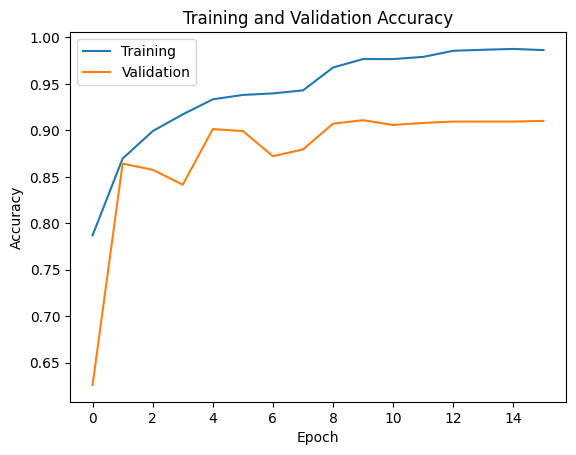

In [20]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

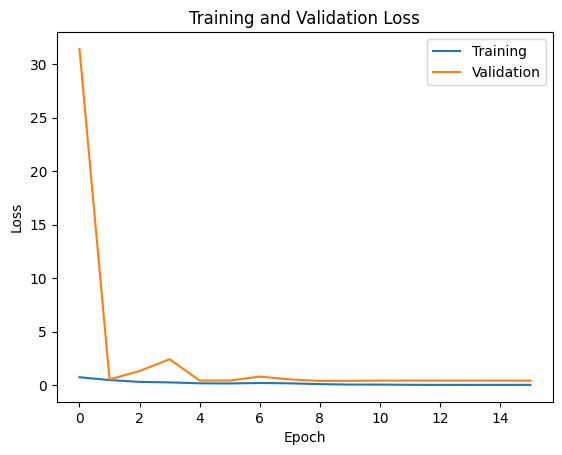

In [21]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step


<Figure size 1000x800 with 0 Axes>

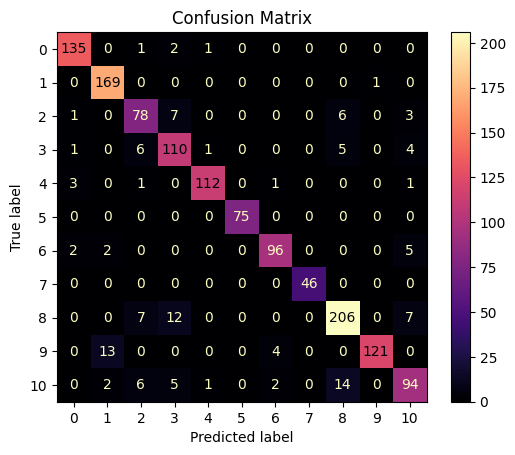

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = validation_scaled_data.classes

pred_probs = premodel.predict(validation_scaled_data, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(10, 8))
disp.plot(cmap='magma')
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

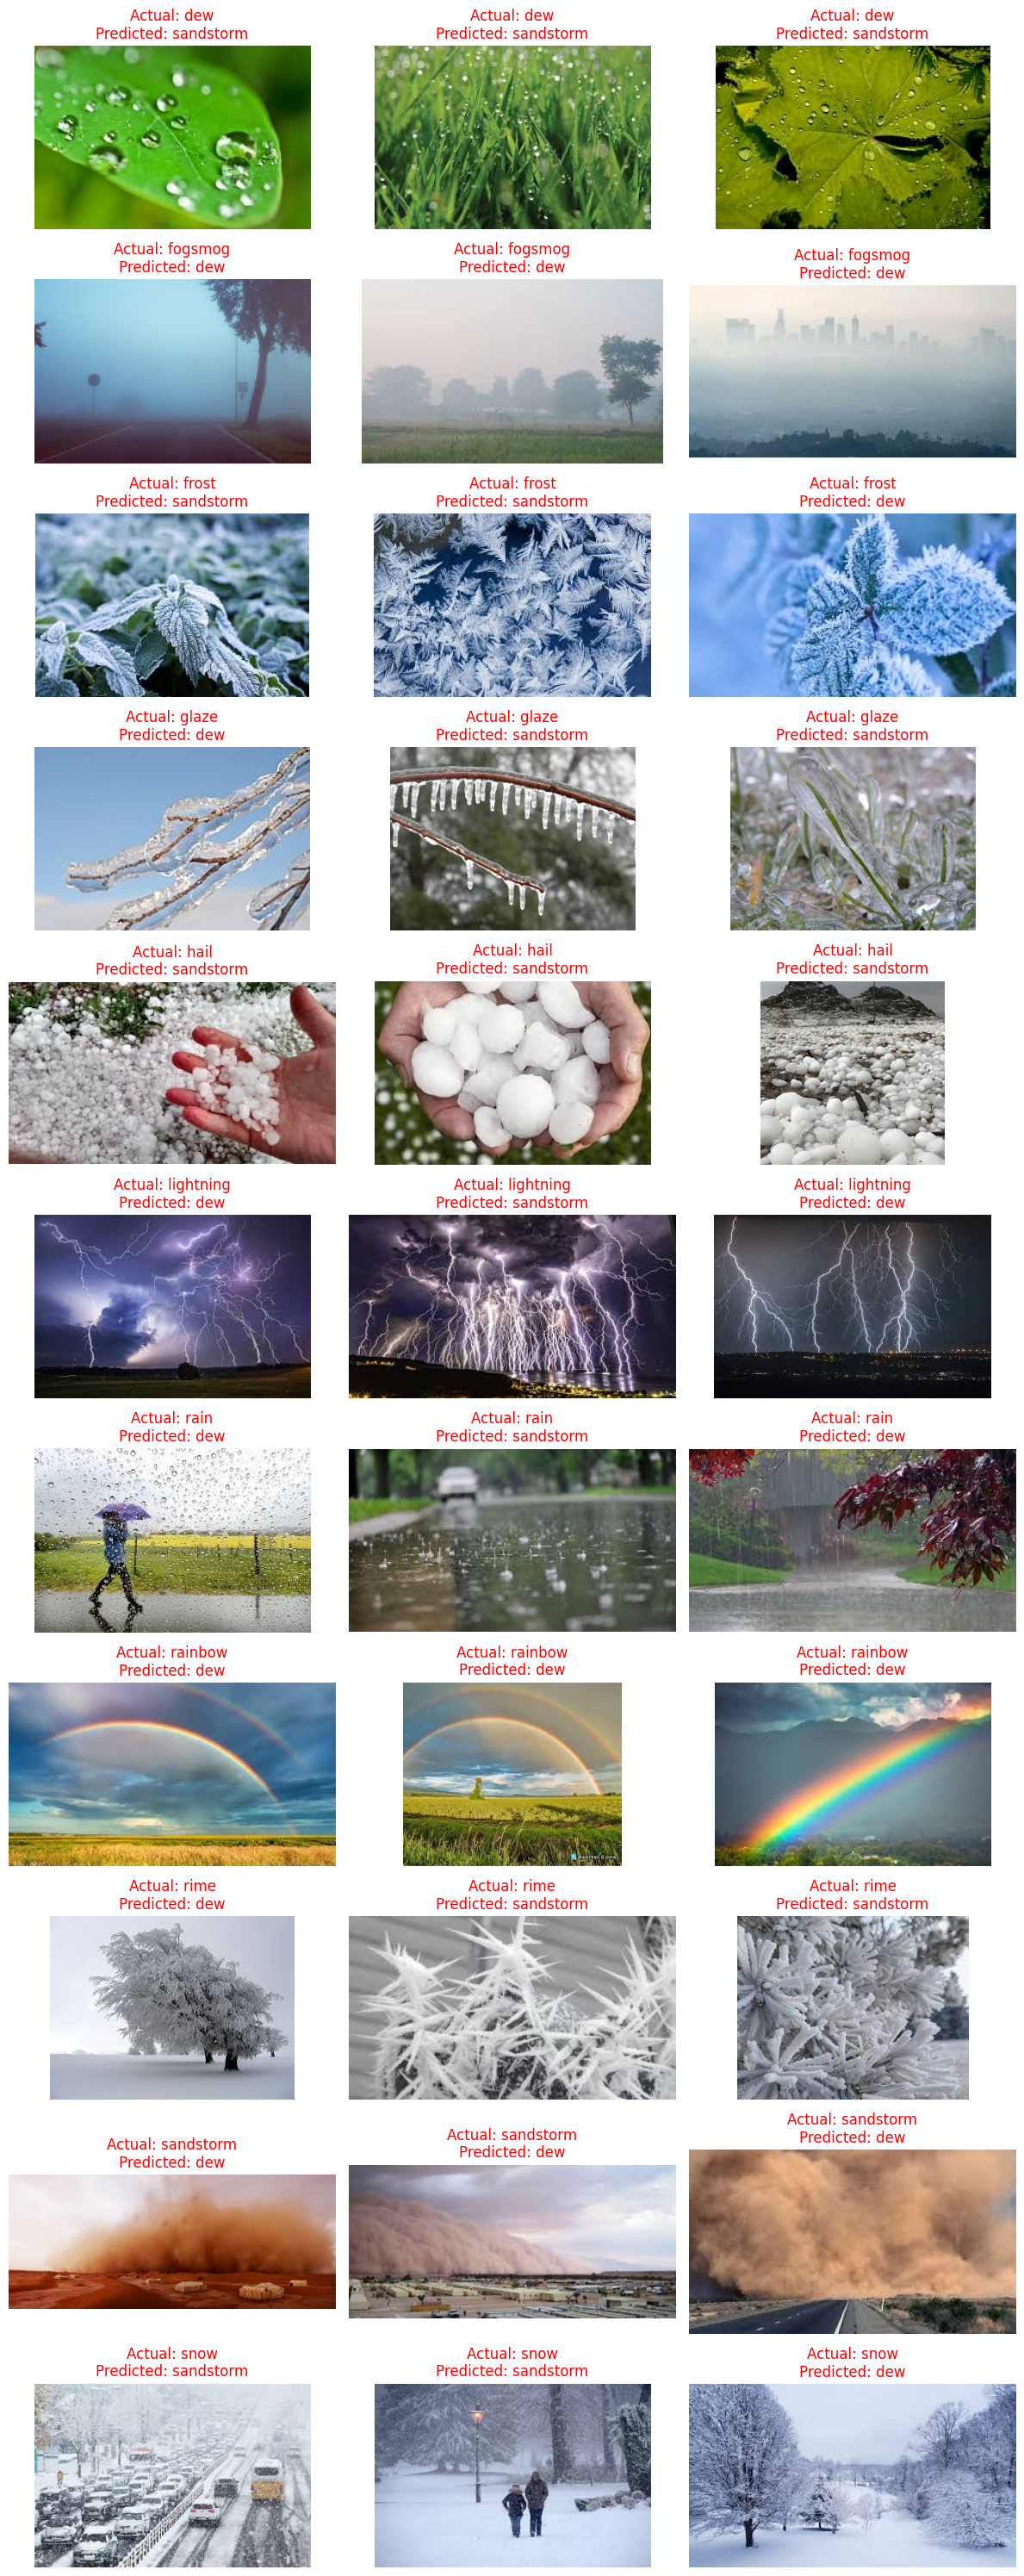

In [26]:
model_test = premodel
test_path = "/content/drive/MyDrive/test"
class_labels = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']

selected_images = []
actual_labels = []

for class_name in class_labels:
    class_dir = os.path.join(test_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
    if len(images) < 2:
        print(f"Warning: Only {len(images)} images found in {class_name}, using all available images.")
    selected_images.extend(random.sample(images, min(3, len(images))))
    actual_labels.extend([class_name] * min(3, len(images)))

plt.figure(figsize=(12,30))

for i, img_path in enumerate(selected_images):
    predicted_label = predict_image(img_path)
    try:

        img = image.load_img(img_path)
        plt.subplot(11, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        title_color = 'green' if predicted_label == actual_labels[i] else 'red'
        plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_label}", color=title_color)

    except Exception as e:
        print(f"Error displaying image {img_path}: {e}")

plt.tight_layout()
plt.show()